In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Solamente para usuarios de Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [2]:

from get_images import get_images

In [3]:
# MNIST path
mnist_path = './mnist_raw/'

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)
x_test_num.shape


(10000, 28, 28)

In [4]:

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32) 
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float) 
y_test = y_test_num.copy().reshape(10000, 1)

/tmp/ipykernel_15594/2211372728.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
/tmp/ipykernel_15594/2211372728.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)


In [8]:
y_test

array([[7],
       [2],
       [1],
       ...,
       [4],
       [5],
       [6]], dtype=uint8)

In [9]:
def normalise(x_mean, x_std, x_data):
    return (x_data-x_mean)/x_std

In [10]:
x_mean = x_train.mean()
x_std = x_train.std()
x_train = normalise(
    x_mean,
    x_std,
    x_train)

x_val = normalise(
    x_mean,
    x_std,
    x_val)

x_test = normalise(
    x_mean,
    x_std,
    x_test)



In [11]:
print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


In [12]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 4


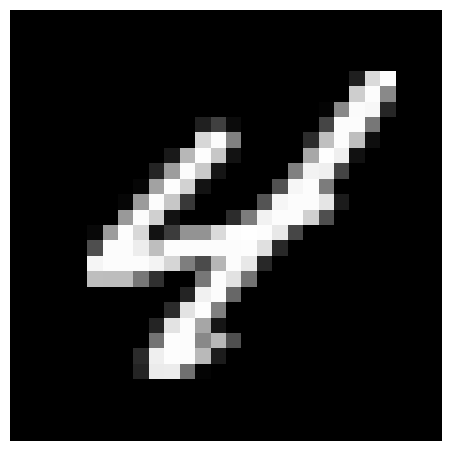

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx][0]}')
plot_number(x_test_num[rnd_idx])

In [14]:
x_train.shape[0]


50000

In [15]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Nuestra clase Lineal, ReLU y Squential

In [16]:
class np_tensor(np.ndarray): pass



# Clase Linear

In [17]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) /  np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    
    def __call__(self, X):
        return self.W @ X + self.b

    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)
        
        

# Clase ReLU


In [18]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z<=0] = 0

# Clase Sequential

In [19]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
        
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs[f'l{i}'] = self.x
        return self.x 
    
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(
                self.outputs[f'l{i}'],
                self.outputs[f'l{i+1}'])
    
    def update(self, learning_rate=1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W -= layer.W.grad * learning_rate
            layer.b -= layer.b.grad * learning_rate
            
    def predict(self, X):
        return np.argmax(self.__call__(X))
        
                
        
        

# Cost Function

In [20]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis=0)
    
    preds = probs.copy()
    
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)] # Revisar cómo funciona    
    cost = np.sum(-np.log(y_hat) / batch_size)
    
    # Calcular gfradiente
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()
    
    return preds, cost

# Loop de entrenamiento

In [53]:
def train(model, epochs, mb_size=128, learning_eate=1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
    
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'epoch {epoch+1}')
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [54]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct / total

In [55]:
model = Sequential_layers(
[
    Linear(784, 200),
    ReLU(),
    Linear(200, 200),
    ReLU(),
    Linear(200, 10)
])

mb_size = 512
learning_rate = 1e-4
epochs = 20 

In [56]:
train(model, epochs, mb_size, learning_rate)

(512, 1)
(10, 512)
epoch 1


UnboundLocalError: local variable 'cost' referenced before assignment

In [51]:
accuracy(x_test, y_test, mb_size)

np_tensor(0.1465)

In [26]:
accuracy(x_test, y_test, mb_size)

np_tensor(0.9706)

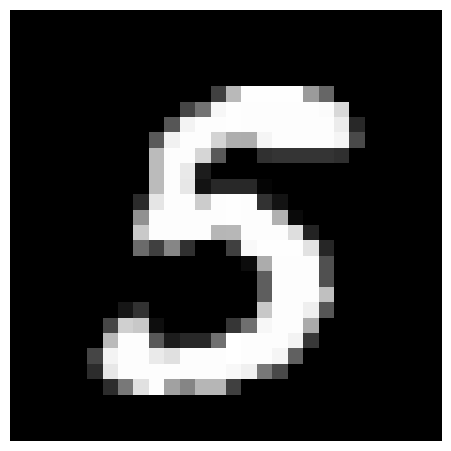

El valor predicho es: 5, y el valor real es: 5


In [38]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'El valor predicho es: {pred}, y el valor real es: {y_test[idx][0]}')